In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import itertools
from datetime import date, datetime, timedelta
from tqdm import tqdm

## Load COVID-19 historical data

In [34]:
data_path = os.path.join('data')

# Read confirmed cases
df_cases_raw = pd.read_csv(os.path.join(data_path,'cases.csv'))        # read csv
df_cases_raw = df_cases_raw.query(" location == 'Bogotá D.C.-Bogotá d C.' ")    # get only for Bogotá
df_cases_raw['date_time'] = pd.to_datetime(df_cases_raw['date_time'], format='%Y-%m-%d')    # converted to datetime

# Perform rolling average over data
rolling_window_size = 7     # days
date_times = df_cases_raw['date_time'].tolist()

# Get data of interest
confirmed_cases = df_cases_raw['num_cases'].rolling(window=rolling_window_size).mean().tolist()
confirmed_deaths = df_cases_raw['num_diseased'].rolling(window=rolling_window_size).mean().tolist()
confirmed_hospital = df_cases_raw['num_infected_in_hospital'].rolling(window=rolling_window_size).mean().tolist()
confirmed_house = df_cases_raw['num_infected_in_house'].rolling(window=rolling_window_size).mean().tolist()

dict_cases = dict(zip(['date_time','confirmed_cases','confirmed_deaths','confirmed_hospital','confirmed_house'],
                      [date_times,confirmed_cases,confirmed_deaths,confirmed_hospital,confirmed_house]))

df_cases = pd.DataFrame(data=dict_cases)

## Load and visualize mobility data

In [64]:
rolling_window_size = 7     # days

df_movement_range_raw = pd.read_csv(os.path.join(data_path, 'movement_range.csv'), parse_dates=['date_time']).set_index('poly_id')
df_movement_range_raw = df_movement_range_raw.loc[11001].sort_values(by='date_time')
df_movement_range_raw["7d_rolling"] = df_movement_range_raw['movement_change'].rolling(window=rolling_window_size).mean()
df_movement_range_raw["7d_rolling"].iloc[:rolling_window_size-1] = df_movement_range_raw["movement_change"].iloc[:rolling_window_size-1]

/opt/anaconda3/envs/datascience/lib/python3.7/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


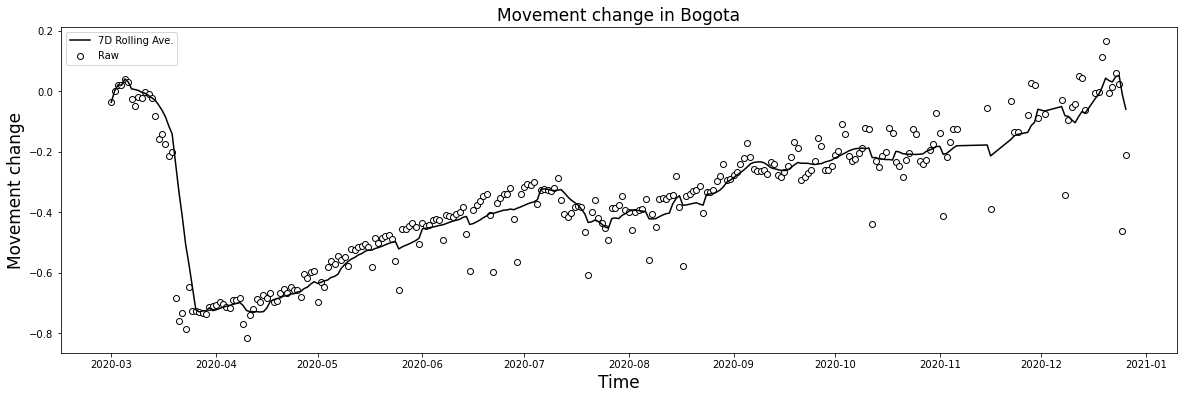

In [66]:
fig, ax = plt.subplots(1, 1, figsize=(20, 6))
ax.scatter(df_movement_range_raw.date_time, df_movement_range_raw["movement_change"], facecolor='w', edgecolors='k', label='Raw')
ax.plot(df_movement_range_raw.date_time, df_movement_range_raw["7d_rolling"], color='k', label='7D Rolling Ave.')
ax.set_ylabel('Movement change',fontsize=17)
ax.set_xlabel('Time',fontsize=17)
ax.set_title('Movement change in Bogota',fontsize=17)
ax.legend()
plt.show()

## Visualize Google trends data
### Data corresponding to official symptoms of COVID-19, terms COVID-19-related terms with potential to track confirmed cases, and terms used to successfully track ILI activity.

In [85]:
# Import API for Google Trends
from pytrends.request import TrendReq
from pytrends import dailydata
from utils import gtrend

# Read search terms
df_search_terms   = pd.read_csv(os.path.join('data','Google_Trends','search_terms_ES.csv'))
search_terms_list = df_search_terms['term'].tolist()

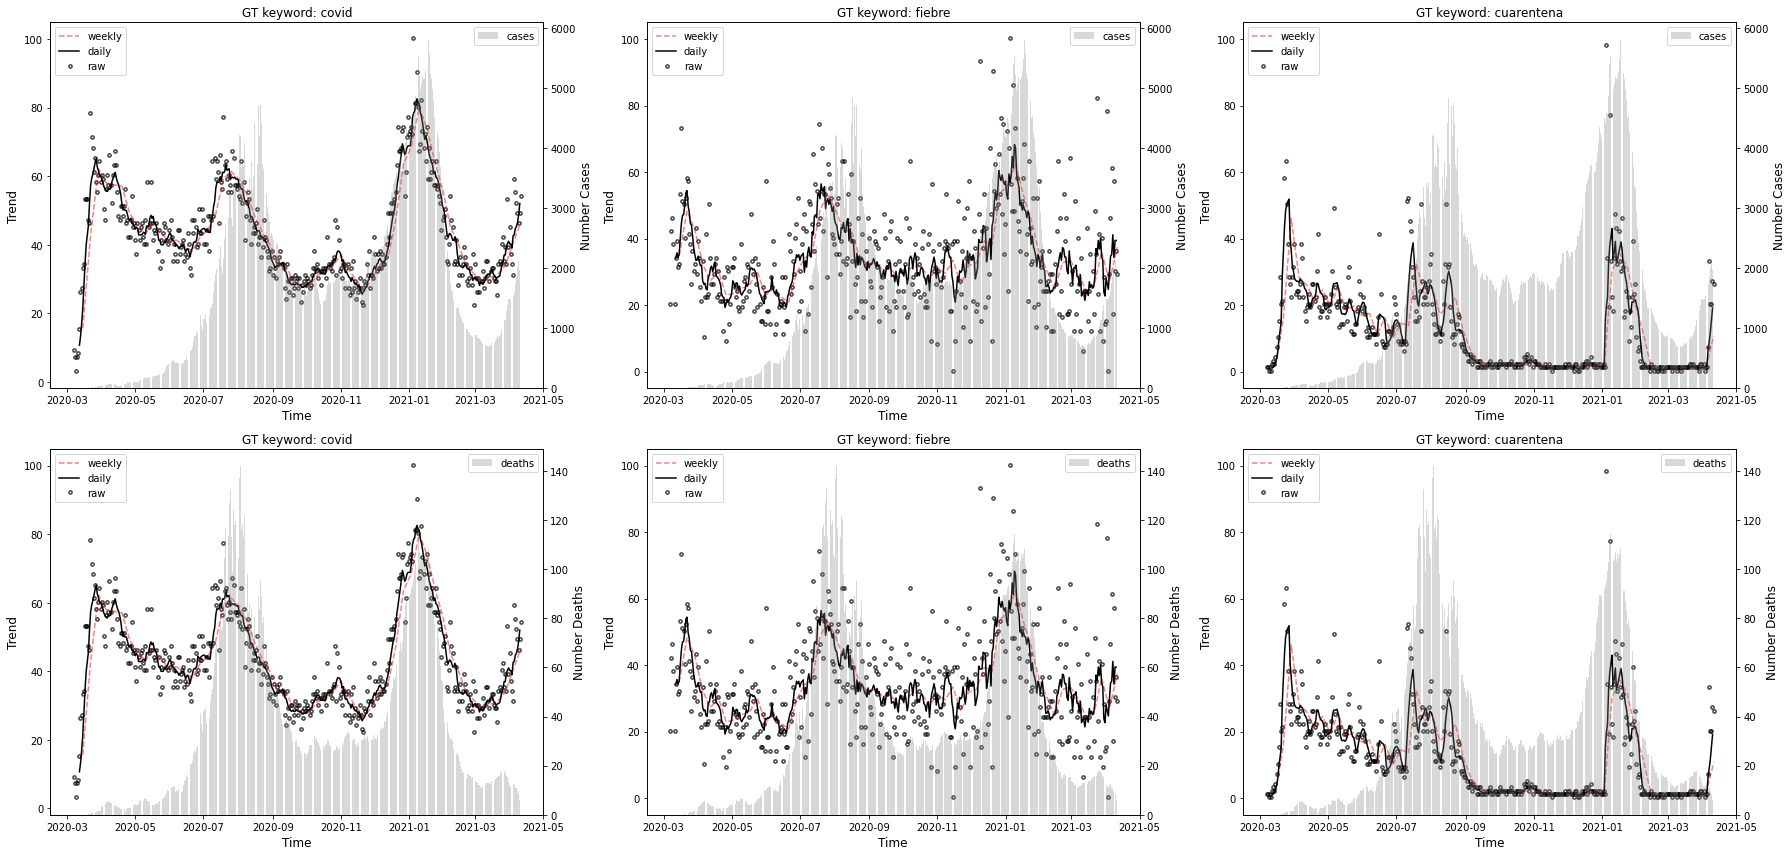

In [90]:
pytrend = TrendReq(hl='es-CO')
keywords_test = ['covid','fiebre','cuarentena']
start = '2020-03-06'
end = '2021-04-10'
geo = 'CO-DC'
cat = 0
gprop=''
rolling_window_size = 7     # days

# Plot data
fig, ax = plt.subplots(2,3,figsize=(25, 12))
for i, kw in enumerate(keywords_test):
    # Read and process
    overlapping = gtrend.get_daily_trend(pytrend, kw, start, end, geo=geo, cat=cat, gprop=gprop, verbose=False)
    overlapping = overlapping.reset_index()
    overlapping["date"] = pd.to_datetime( overlapping["date"] )
    overlapping['rw'] = overlapping[kw].rolling(window=rolling_window_size).mean()
    overlapping["end_day"] = overlapping.apply(lambda x: x["date"] - timedelta(days=x['date'].weekday()) + timedelta(days=6), axis=1)
    overlapping_week = overlapping.groupby(['end_day']).mean().reset_index()
    # Plot GT
    ax[0,i].scatter(x=overlapping['date'], y=overlapping[kw], marker="$\circ$", color='k', alpha=0.5, label='raw')
    ax[0,i].plot(overlapping_week['end_day'], overlapping_week['rw'], color='r', linestyle='dashed', alpha=0.5, label='weekly')
    ax[0,i].plot(overlapping['date'], overlapping['rw'], color='k', label='daily')
    ax[0,i].legend(loc='upper left')
    ax[0,i].set_xlabel('Time',fontsize=12)
    ax[0,i].set_ylabel('Trend',fontsize=12)
    ax[0,i].set_title(f'GT keyword: {kw}',fontsize=12)
    # Plot cases
    ax1 = ax[0,i].twinx()
    ax1.bar(df_cases['date_time'], df_cases['confirmed_cases'], color='gray', alpha=0.3, label='cases')
    ax1.set_ylabel('Number Cases',fontsize=12)
    ax1.legend(loc='upper right')
    # Plot GT
    ax[1,i].scatter(x=overlapping['date'], y=overlapping[kw], marker="$\circ$", color='k', alpha=0.5, label='raw')
    ax[1,i].plot(overlapping_week['end_day'], overlapping_week['rw'], color='r', linestyle='dashed', alpha=0.5, label='weekly')
    ax[1,i].plot(overlapping['date'], overlapping['rw'], color='k', label='daily')
    ax[1,i].legend(loc='upper left')
    ax[1,i].set_xlabel('Time',fontsize=12)
    ax[1,i].set_ylabel('Trend',fontsize=12)
    ax[1,i].set_title(f'GT keyword: {kw}',fontsize=12)
    # Plot deaths
    ax2 = ax[1,i].twinx()
    ax2.bar(df_cases['date_time'], df_cases['confirmed_deaths'], color='gray', alpha=0.3, label='deaths')
    ax2.set_ylabel('Number Deaths',fontsize=12)
    ax2.legend(loc='upper right')

plt.tight_layout()
plt.show()

### Using related terms

In [108]:
# Read files containing main termss
df_main_terms = pd.read_csv(os.path.join('data','Google_Trends','terms_id_ES.csv'))

# Read trends for Bogota
df_trends_BOG = pd.read_csv(os.path.join(data_path,'Google_Trends','trends_BOG.csv'),index_col=1)
df_trends_BOG_kw = df_trends_BOG.columns.values[1:]

# Get relationships
map_term_2_r = dict(zip(df_search_terms['term'], df_search_terms['r']))
map_r_2_term = dict(zip(df_main_terms['r'], df_main_terms['id']))

# Select relationships (r) to plot
r_select = [0,2,3,4,5,6,7,9,10,12,13,16,17,19,24,25]

In [96]:
def get_weighted_average(df_entry, maximuns):
    df_mean = df_entry.copy()
    df_mean = df_mean.dropna()
    df_mean["weights"] = list(itertools.chain(*[[w]*(len(df_mean)//len(maximuns)) for w in maximuns]))  
    df_wa = df_mean.groupby(['date']).apply(lambda x: pd.Series([ np.average(x['rw'], weights=x['weights']) ]) ).reset_index()
    return df_wa

100%|██████████| 16/16 [00:14<00:00,  1.09it/s]


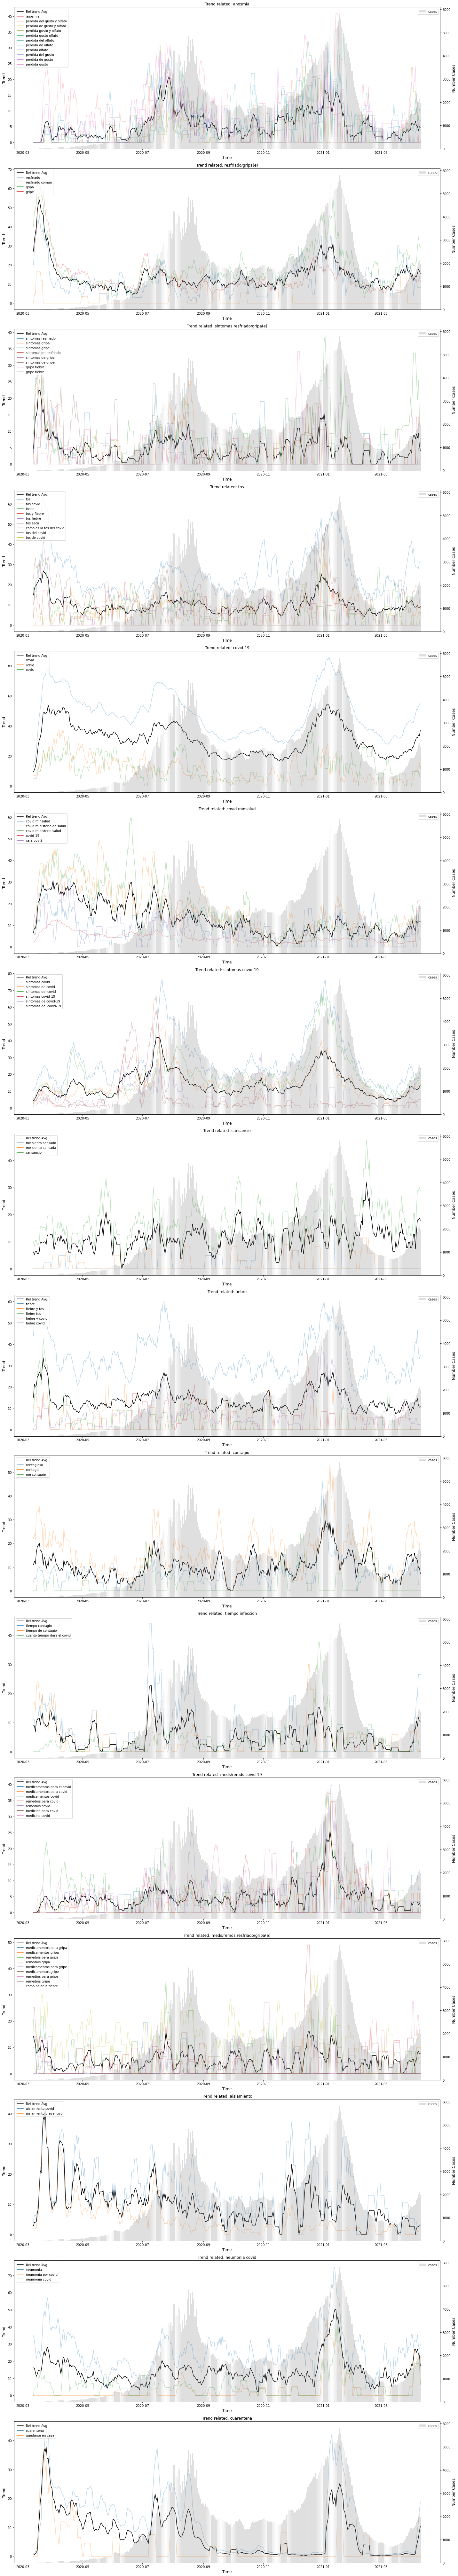

In [110]:
fig, ax = plt.subplots(len(r_select),1,figsize=(20,7*len(r_select)))
for i, r in tqdm(enumerate(r_select), total=len(r_select)):
    # Get related terms
    df_related_terms = []
    maximuns = []
    for kw in df_trends_BOG_kw:
        if r == map_term_2_r[kw]:
            kw_trend = df_trends_BOG[kw]; kw_trend = kw_trend.reset_index()
            kw_trend["date"] = pd.to_datetime( kw_trend["date"] ) #; kw_trend.set_index('date')
            kw_trend['rw']   = kw_trend[kw].rolling(window=7).mean()
            kw_trend['term'] = [kw]*len(kw_trend)
            kw_trend = kw_trend.drop(columns=[kw])
            df_related_terms.append(kw_trend)
            maximuns.append( kw_trend['rw'].max()/100 )
    df_related_terms = pd.concat( df_related_terms )
    df_weighted_avg  = get_weighted_average(df_related_terms, maximuns)
    # Plot trends
    ax[i].plot(df_weighted_avg['date'], df_weighted_avg[0], color='k', label='Rel trend Avg.')
    sns.lineplot(ax=ax[i], data=df_related_terms, x='date', y='rw', hue='term', alpha=0.3)
    ax[i].legend(loc='upper left')
    ax[i].set_xlabel('Time',fontsize=12)
    ax[i].set_ylabel('Trend',fontsize=12)
    ax[i].set_title('Trend related: ' + str(map_r_2_term[r]),fontsize=12)
    ax1 = ax[i].twinx()
    ax1.bar(df_cases['date_time'], df_cases['confirmed_cases'], color='gray', alpha=0.25, label='cases')
    ax1.set_ylabel('Number Cases',fontsize=12)
    ax1.legend(loc='upper right')
plt.tight_layout()
plt.show()